# Notebook of the project of Physics of Complex Systems #
Implementation of this [article](https://journals.aps.org/pre/abstract/10.1103/PhysRevE.85.031911).

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.integrate import odeint
import os
import concurrent.futures
from scipy.optimize import curve_fit
from tqdm.contrib.telegram import tqdm

import model as m       # Python file with all the functions

# I set some parameters for the whole project
time_steps = 10000    # 1000
dt = 0.1
# Set the time grid for the ODEs
t_s = 0. + dt * np.arange(time_steps)
# parameters initialization (I use the parameters listed in the caption of Figure 3)
par = {
    'alpha': 1.2,   # 1.2
    'gamma': 0.01,   # questo sarebbe 0.01
    'lambda': 0.6,
    'nu': 0.001,
    'sigma': 0.01,
    'Dx': 0.,       # diffusion of x
    'Dy': 0.        # diffusion of y
}
# Define some meaningful quantities for the analysis
y0 = par['lambda']/par['sigma']
#y0 = 4 # from Figure 1
y_star = par['alpha']/par['gamma']
x_star = (par['sigma']-par['lambda']*par['gamma']/par['alpha'])/par['nu']
os.makedirs("plots", exist_ok=True)
m.stability(par)

In which regime are we? First regime:(0,y_0) unstable, (x*,y*) stable
The attractor (x*,y*) is a stable spiral (negative discriminant -> damped oscillations)


/home/pietromalagoli/miniconda3/envs/uni/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Functions

Firstly, I try to reproduce the mean-field approach. The resulting system of ODEs is the following:
$$
    \frac{\partial x}{\partial t} = \alpha x - \gamma xy , \;\;\;
    \frac{\partial y}{\partial t} = \lambda + \nu xy - \sigma y
$$
where $x$ is the pathogen concentration and $y$ the lymphocytes'. \
The parameters represent:
- $\alpha$ : proliferation rate of the pathogen; 
- $\gamma$ : destruction rate of the pathogen by the lymphocytes; 
- $\lambda$ : birth rate of the lymphocyte; 
- $\nu$ : duplication rate of the lymphocyte when encountering the pathogen; 
- $\sigma$ : death rate of the lymphocyte. 
# Mean Field Approach #

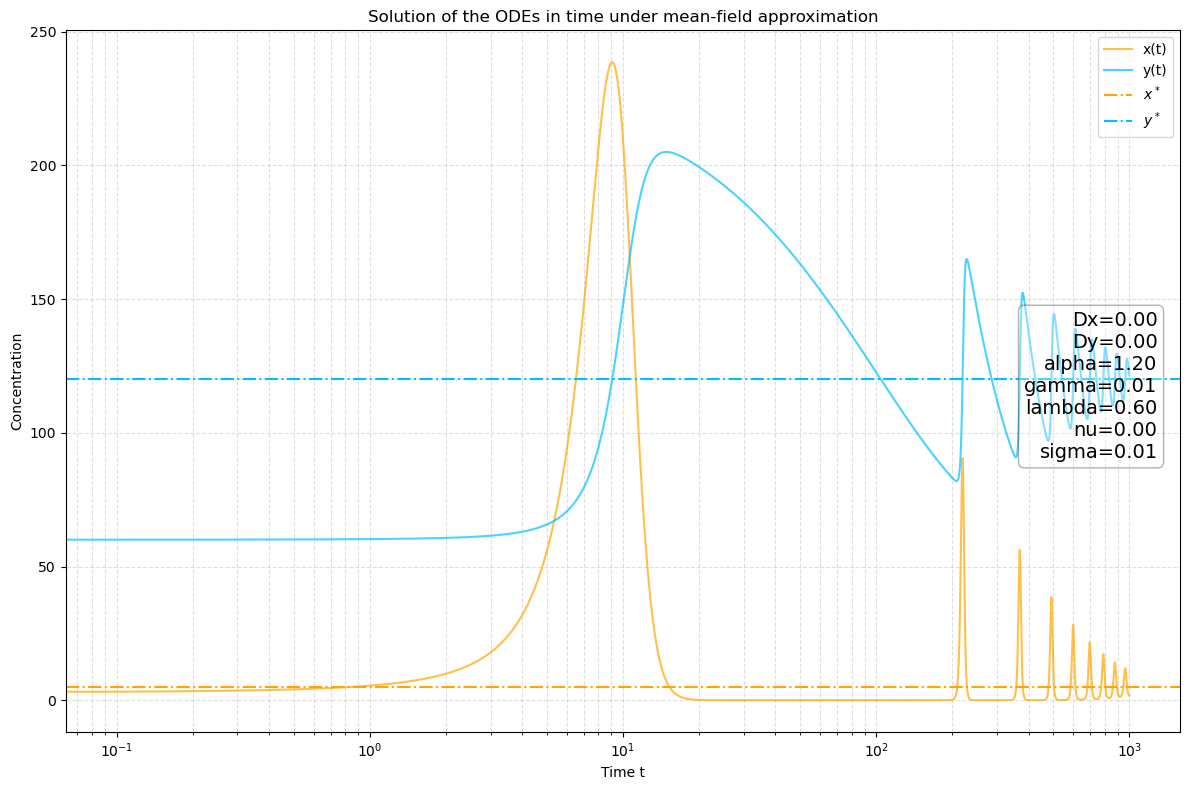

In [2]:
# set initial conditions
#z0 = np.array([3,np.random.poisson(lam=1)])    # z=[x,y]
#z0 = np.array([x_star,y_star])    # z=[x*,y*] (I try to initialize at a fixed point to verify stability)
z0 = np.array([3,y0])

# Solve
X_ode = odeint(m.system,z0,t_s,args=(par,))[:,0]
Y_ode = odeint(m.system,z0,t_s,args=(par,))[:,1]

'''
# Normalization
X_ode /= np.max(X_ode)
Y_ode /= np.max(Y_ode)

y_tilde = Y_ode[np.argmin(np.abs(X_ode-1))]
Dt1 = (1/par['gamma'])*(np.log((y_tilde-
                                par['gamma']/par['sigma'])/
                               (par['alpha']/par['gamma']-
                               par['lambda']/par['sigma'])))
'''

# Solution of the X ODE
plt.figure(figsize=(12,8))
plt.plot(t_s, X_ode, c='orange', label='x(t)',alpha=0.7)
plt.plot(t_s, Y_ode, c='deepskyblue', label='y(t)',alpha=0.7)
plt.title('Solution of the ODEs in time under mean-field approximation')
plt.axhline(y=x_star,label=r'$x^*$',c='orange',linestyle='-.')
plt.axhline(y=y_star,label=r'$y^*$',c='deepskyblue',linestyle='-.')
plt.xlabel('Time t')
plt.ylabel('Concentration')
plt.xscale('log')
plt.grid(True, which="both",alpha=0.4,linestyle='--')
m.add_par_box(par)
plt.legend(loc='upper right')
plt.tight_layout()
plt.savefig('plots/ODE.png')
#plt.show()

The time it takes for $y$ to reach $\tilde{y}$, which is the value of $y$ for which $x=1$, is approximately:
$$
\Delta t_1 = \frac{1}{\gamma}\ln\left(\frac{\tilde{y}-\frac{\lambda}{\sigma}}{\frac{\alpha}{\gamma}-\frac{\lambda}{\sigma}}\right)
$$
while, the time it takes for $x$ to increase from 1 to a larger number $k$ is:
$$
\Delta t_2 = \frac{1}{\alpha}\ln k
$$
Now I recreate the trajectory of the solutions of the ODE

In [3]:
%%script false --no-raise-error
m.stability(par)

fig,ax = plt.subplots(1,2,figsize=(16,6))
# Trajectory of the solutions over time
ax[0].plot(X_ode, Y_ode, c='orange', label='y(t)',alpha=0.7)
ax[0].set_title('Trajectory of the solution of the ODEs in mean-field approximation')
ax[0].scatter(0,y0, c='r',marker='^',label=r'$(0,y_0)$')
ax[0].scatter(x_star,y_star, c='r',marker='*',label=r'$(x^*,y^*)$')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[0].grid(True, which="both",alpha=0.4,linestyle='--')
m.add_par_box(par)

# Trajectory of the solutions over time zoomed
ax[1].plot(X_ode, Y_ode, c='orange', label='y(t)',alpha=0.7)
ax[1].axvline(1,c='r',linestyle='-.',label='x=1',alpha=0.7)
ax[1].axvline(0,c='black',linestyle='--',alpha=0.3)
ax[1].set_title('Trajectory of the solution of the ODEs in mean-field approximation (ZOOM)')
ax[1].scatter(0,y0, c='r',marker='^',label=r'$(0,y_0)$')
ax[1].scatter(x_star,y_star, c='r',marker='*',label=r'$(x^*,y^*)$')
ax[1].set_xlim(-2,10)
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
ax[1].grid(True, which="both",alpha=0.4,linestyle='--')
m.add_par_box(par)
plt.legend(loc='upper right')
plt.savefig('plots/Fig1.png')
plt.show()

In [4]:
%%script false --no-raise-error
def P_da(x,y,par,y0):
    # this I've obtained from the expression for the disappearance probability at page 4 (see paper notes)
    #return 1-np.exp(-par['gamma']*(par['lambda']+y*(par['nu']*x-par['sigma'])-par['sigma']*y0))
    return 1-np.exp(-par['gamma']*par['sigma']*(y-y0))      # here, as suggested in page 3, I ignore the term $\nu xy$ in y', since x is small.
    #return par['gamma']*y
    
#plt.plot(P_da(X_ode,Y_ode,par,y0)/np.max(P_da(X_ode,Y_ode,par,y0)))
plt.plot(P_da(X_ode,Y_ode,par,y0))
plt.title('Analytical probability of disappearance')
plt.xlabel('Time t')
plt.ylabel('X')
plt.xscale('log')
plt.grid(True, which="both",alpha=0.4,linestyle='--')
# Create a box plot for the parameters in 'par'
m.add_par_box(par)

## Lattice ##
The interactions between pathogens and lymphocytes are described by the following reactions:
$$
\begin{gather}
    X \xrightarrow{\alpha} X + X \\
    \emptyset \xrightarrow{\lambda} Y \\
    X + Y \xrightarrow{\gamma} Y  \\
    X + Y \xrightarrow{\nu} X + 2Y \\
    Y \xrightarrow{\sigma} \emptyset .
\end{gather}
$$
### 1D ##
Firstly, I try a toy model of a 1D lattice with 100 cells and no diffusion (mean-field approximation):

In [5]:
%%script false --no-raise-error
par['alpha'] = 1.6
par['nu'] = 0.001
par

In [6]:
%%script false --no-raise-error
m.stability(par)
time_steps = int(1e4)    # 1000
t_s = 0. + dt * np.arange(time_steps)
z0 = np.array([3,y0])       # set initial conditions
# Solve again the ODEs so to have it with the right parameters, in case that they're different for the stochastic case
X_ode = odeint(m.system,z0,t_s,args=(par,))[:,0]
Y_ode = odeint(m.system,z0,t_s,args=(par,))[:,1]
# Compute the model
args = [10000,time_steps, dt, par,False]     # [N,time_steps,par,fill]
X_stoc, Y_stoc = m.lattice1(args)

scalex = 1#np.max(X_stoc)/np.max(X_ode)
scaley = 1#np.max(Y_stoc)/np.max(Y_ode)
# plot the evolution of x(t)
fig, ax = plt.subplots(2,2,figsize=(14,12))
ax[0,0].plot(X_stoc/scalex,c='orange',label='x(t)-Stochastic',alpha=0.7)
ax[0,0].plot(X_ode,c='deepskyblue',label='x(t)-MFT',alpha=0.7)          # multiplied by 4 only for scaling
#ax[0,0].axhline(x_star,c='r',linestyle='--',label=r'$x^*$',alpha=0.7)
ax[0,0].set_title('Averaged zero-dimensional stochastic counterpart of the mean-field results')
ax[0,0].set_xlabel('Time t')
ax[0,0].set_ylabel('X')
ax[0,0].set_xscale('log')
ax[0,0].grid(True, which="both",alpha=0.4,linestyle='--')

ax[0,1].plot(X_stoc/scalex,c='orange',label='x(t)-Stochastic',alpha=0.7)
ax[0,1].plot(X_ode,c='deepskyblue',label='x(t)-MFT',alpha=0.7)
#ax[0,1].axhline(x_star,c='r',linestyle='--',label=r'$x^*$',alpha=0.7)
ax[0,1].set_title('ZOOM')
ax[0,1].set_xlim(100,time_steps)
ax[0,1].set_ylim(0,100)
ax[0,1].set_xlabel('Time t')
ax[0,1].set_ylabel('X')
ax[0,1].set_xscale('log')
ax[0,1].grid(True, which="both",alpha=0.4,linestyle='--')

ax[1,0].plot(X_stoc/scalex, Y_stoc/scaley, c='orange', label='Stochastic',alpha=0.7)
ax[1,0].plot(X_ode, Y_ode, c='deepskyblue', label='MFT',alpha=0.7)
ax[1,0].set_title('Trajectory of the solution of the ODEs in mean-field approximation')
#ax[1,0].scatter(0,y0, c='r',marker='^',label=r'$(0,y_0)$')
#ax[1,0].scatter(x_star,y_star, c='r',marker='*',label=r'$(x^*,y^*)$')
ax[1,0].set_xlabel('X')
ax[1,0].set_ylabel('Y')
ax[1,0].grid(True, which="both",alpha=0.4,linestyle='--')

ax[1,1].plot(X_stoc/scalex, Y_stoc/scaley, c='orange', label='Stochastic',alpha=0.7)
ax[1,1].plot(X_ode, Y_ode, c='deepskyblue', label='MFT',alpha=0.7)
ax[1,1].axvline(x=1,c='r',label='x=1',linestyle='--',alpha=0.4)
ax[1,1].set_title('Trajectory of the solution of the ODEs in mean-field approximation')
#ax[1,1].scatter(0,y0, c='r',marker='^',label=r'$(0,y_0)$')
#ax[1,1].scatter(x_star,y_star, c='r',marker='*',label=r'$(x^*,y^*)$')
ax[1,1].set_xlim(-1,10)
ax[1,1].set_xlabel('X')
ax[1,1].set_ylabel('Y')
ax[1,1].grid(True, which="both",alpha=0.4,linestyle='--')
m.add_par_box(par)
plt.legend(loc='upper right')
plt.savefig('plots/stochastic1.png')
plt.show()

Now I study the disappearance probability at the first pass near zero as a function of the distance between the two stable points.\
I only check for having zero pathogen for the zero-pathogen absorbing state; for now I don't care about Y.

I try to use as the first pass near-zero the moment for whihc $y\sim \alpha / \gamma$. In the paper, this is said to happen after a time $\Delta t_1$:
$$
\Delta t_1 = \frac{1}{\sigma}\ln\left[\frac{(\tilde{y} - \frac{\lambda}{\sigma})}{
(\frac{\alpha}{\gamma}-\frac{\lambda}{\sigma})}\right]
$$
where $\tilde{y}$ is the value of $y$ for which $x=1$.\
Such value, we can either extract it analitically from the ODEs or we can retrieve it through simulations. \
As a first approach, we will do the former.

In [7]:
par['alpha'] = 1.2
par['gamma'] = 0.1
par['lambda'] = 0.4
par['sigma'] = 0.1
par['Dx']=0
par['Dy']=0
par

{'alpha': 1.2,
 'gamma': 0.1,
 'lambda': 0.4,
 'nu': 0.001,
 'sigma': 0.1,
 'Dx': 0,
 'Dy': 0}

100%|██████████| 50/50 [28:29<00:00, 34.19s/it]


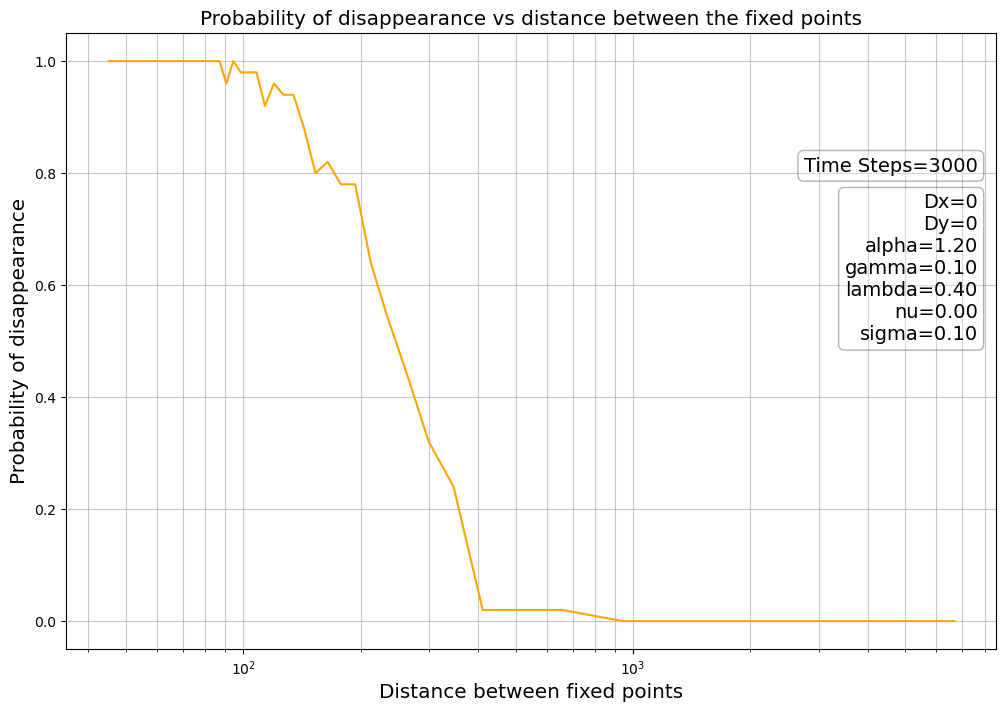

In [8]:
num_nu = 50
n_iter = 50
N=10000
time_steps = 3000
params = [num_nu,N,time_steps,dt,par,n_iter]
P_diss = m.P_diss(m.lattice1,params)
plt.figure(figsize=(12,8))
plt.plot(P_diss[:,0],P_diss[:,1],c='orange')
plt.xscale('log')
plt.title('Probability of disappearance vs distance between the fixed points',fontsize='x-large')
plt.xlabel('Distance between fixed points',fontsize='x-large')
plt.ylabel('Probability of disappearance',fontsize='x-large')
plt.grid(True, which='both',alpha=0.7)
m.add_par_box({'Time Steps':time_steps},coord=[0.98,0.8])
m.add_par_box(par,coord=[0.98,0.74])
plt.savefig('plots/Pdiss.png')
plt.show()

## Diffusion
Now diffusion is added to the stochastic model. In particular, we have an isotropic discrete diffusion regulated by two coefficients, $D_{x}$ and $D_{y}$, for the two populations, respectively pathogens ($x$) and immune system ($y$). The diffusive process is carried out as a Poisson number with mean, e.g. for the pathogen population, $\lambda=D_{x}x$ (where $x$ is the population of the starting site), subtracted from the starting site and added to its neighbours. 

In [ ]:
%%script false --no-raise-error
par['alpha']=1.6
par['gamma']=0.01
par['lambda']=0.6
par['nu']=0.001
par['sigma']=0.01
par['Dx'] = 10
par['Dy'] = 10
print(par)
m.stability(par)

{'alpha': 1.6, 'gamma': 0.01, 'lambda': 0.6, 'nu': 0.001, 'sigma': 0.01, 'Dx': 10, 'Dy': 10}
In which regime are we? First regime:(0,y_0) unstable, (x*,y*) stable
The attractor (x*,y*) is a stable spiral (negative discriminant -> damped oscillations)


### 1D

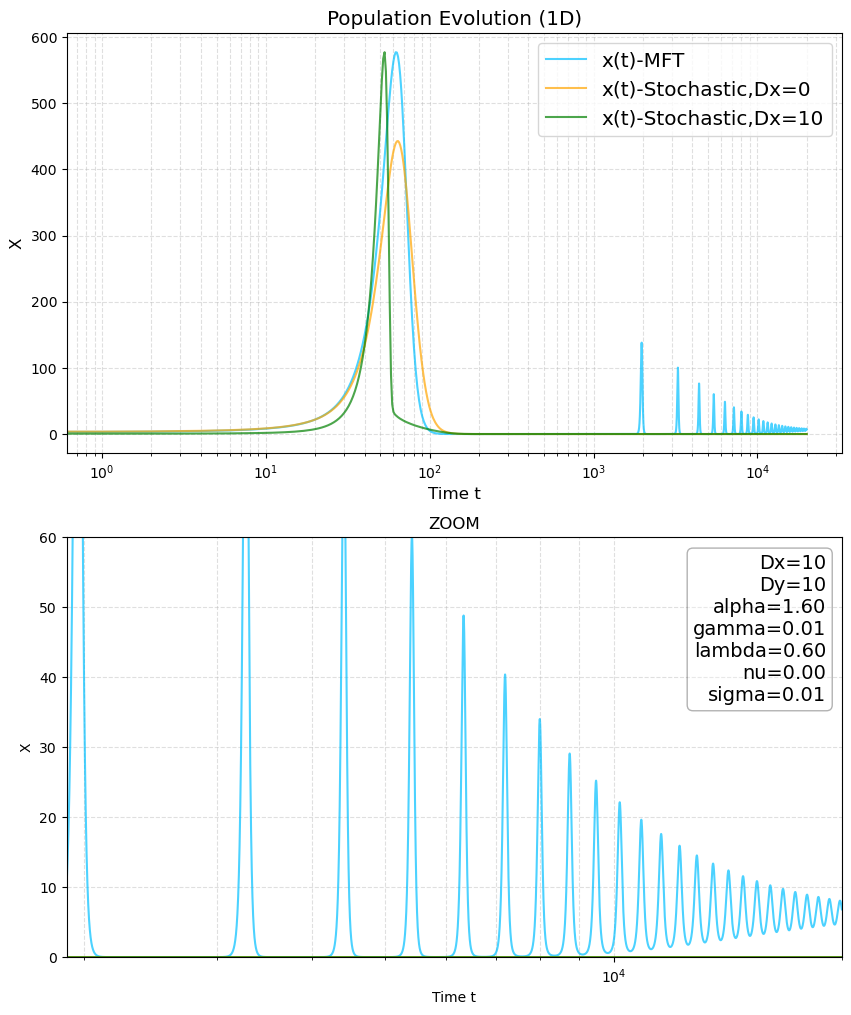

In [ ]:
%%script false --no-raise-error
dim = 1
time_steps = 20000
z0 = np.array([3,y0])       # set initial conditions
params = [10000,time_steps,dt,z0,par,0]
N, time_steps, dt, z0, par, mode = params
models = [m.lattice1,m.lattice2,m.lattice3]
model = models[dim-1]
t_s = 0 + dt * np.arange(time_steps)
# Solve again the ODEs so to have it with the right parameters, in case that they're different for the stochastic case
sol = odeint(m.system,z0,t_s,args=(par,))
X_ode = sol[:,0]
local_par = par.copy()
local_par['Dx'] = 0
local_par['Dy'] = 0
X_stoc, _ = model([10000,time_steps,dt,local_par,0])
if mode == 2:
    X_ode = 0
    Y_ode = 0
args = [N,time_steps,dt,par,mode]     # [N,time_steps,par,mode]
X_diff, _ = model(args)

if mode == 0:
    scalex = np.max(X_diff)/(np.max(X_ode) or 1)
else:
    scalex = 1

fig, ax = plt.subplots(2,1,figsize=(10,12))
# plot the evolution of x(t)
ax[0].plot(X_ode,c='deepskyblue',label='x(t)-MFT',alpha=0.7)
ax[0].plot(X_stoc,c='orange', label=f'x(t)-Stochastic,Dx={local_par['Dx']}',alpha=0.7)      
ax[0].plot(X_diff/scalex,c='green',label=f'x(t)-Stochastic,Dx={par['Dx']}',alpha=0.7)
ax[0].set_title(f'Population Evolution ({dim}D)' if mode == 0 else f'Filling Fraction ({dim}D)',fontsize='x-large')
ax[0].set_xlabel('Time t',fontsize='large')
ax[0].set_ylabel('X',fontsize='large')
ax[0].set_xscale('log')
ax[0].grid(True, which="both",alpha=0.4,linestyle='--')
ax[0].legend(loc='upper right',fontsize='x-large')

ax[1].plot(X_ode,c='deepskyblue',label='x(t)-MFT',alpha=0.7)
ax[1].plot(X_stoc/scalex,c='orange',label=f'x(t)-Stochastic,Dx={local_par['Dx']}',alpha=0.7)
ax[1].plot(X_diff/scalex,c='green',label=f'x(t)-Stochastic,Dx={par['Dx']}',alpha=0.7)
ax[1].set_title('ZOOM')
ax[1].set_xlim(1900,time_steps)
ax[1].set_ylim(0,60)
ax[1].set_xlabel('Time t')
ax[1].set_ylabel('X')
ax[1].set_xscale('log')
ax[1].grid(True, which="both",alpha=0.4,linestyle='--')
m.add_par_box(par,coord=[0.98,0.96])
plt.savefig('plots/Fig3.png')
plt.show()

# Filling Fraction: Direct Percolation vs Stochastic Diffusion

In [12]:
par['alpha']=1.2
par['gamma']=0.2
par['lambda']=0.6
par['nu']=0.08
par['sigma']=0.58
par['Dy']=0.025
m.stability(par)
par

In which regime are we? First regime:(0,y_0) unstable, (x*,y*) stable
The attractor (x*,y*) is a stable spiral (negative discriminant -> damped oscillations)


{'alpha': 1.2,
 'gamma': 0.2,
 'lambda': 0.6,
 'nu': 0.08,
 'sigma': 0.58,
 'Dx': 10,
 'Dy': 0.025}

In [13]:
## 1D
n_iter = 50     # number of iterations per set of parameters
Pspan = np.linspace(0,0.4,15)     # set of probabiilty of invasion
dim = 1
models_DP = [m.DP1d,m.DP2d,m.DP3d]
params_DP = [10000, 500, 0.19, n_iter]      # [N, timesteps, Pdis, n_iter]
fillings_DP1 = m.filling_fraction_DP(model=models_DP[dim-1],Pspan=Pspan,params=params_DP)
models_ST = [m.lattice1,m.lattice2,m.lattice3]
params_ST = [10000, 500, 0.1, par, n_iter]   
fillings_ST1 = m.filling_fraction_ST(model=models_ST[dim-1],Pspan=Pspan,params=params_ST)

  0%|          | 0/15 [00:00<?, ?it/s]

DP: set#0


 67%|██████▋   | 10/15 [00:46<00:24,  4.89s/it]

DP: set#10


  0%|          | 0/15 [00:00<?, ?it/s]

ST: set#0


 67%|██████▋   | 10/15 [02:26<01:24, 16.86s/it]

ST: set#10


100%|██████████| 15/15 [20:25<00:00, 81.69s/it] 


In [ ]:
## 2D
Pspan = np.linspace(0,0.4,15)     # set of probabiilty of invasion
dim = 2
params_DP = [100, 500, 0.35, n_iter]      # [N, timesteps, Pdis, n_iter]
fillings_DP2 = m.filling_fraction_DP(model=models_DP[dim-1],Pspan=Pspan,params=params_DP)
params_ST = [100, 500, dt, par, n_iter]   
fillings_ST2 = m.filling_fraction_ST(model=models_ST[dim-1],Pspan=Pspan,params=params_ST)

  0%|          | 0/15 [00:00<?, ?it/s]

DP: set#0


 67%|██████▋   | 10/15 [00:42<00:21,  4.34s/it]

DP: set#10


  0%|          | 0/15 [00:00<?, ?it/s]

ST: set#0


 67%|██████▋   | 10/15 [02:25<01:17, 15.53s/it]

ST: set#10


100%|██████████| 15/15 [03:52<00:00, 15.47s/it]


  0%|          | 0/15 [00:00<?, ?it/s]

DP: set#0


 67%|██████▋   | 10/15 [00:40<00:22,  4.51s/it]

DP: set#10


  0%|          | 0/15 [00:00<?, ?it/s]

ST: set#0


 67%|██████▋   | 10/15 [02:51<01:35, 19.13s/it]

ST: set#10


  0%|          | 0/15 [00:00<?, ?it/s]

DP: set#0


 67%|██████▋   | 10/15 [01:19<00:43,  8.69s/it]

DP: set#10


  0%|          | 0/15 [00:00<?, ?it/s]

ST: set#0


 67%|██████▋   | 10/15 [04:06<02:13, 26.75s/it]

ST: set#10


  0%|          | 0/15 [00:00<?, ?it/s]

DP: set#0


 67%|██████▋   | 10/15 [02:14<01:09, 13.83s/it]

DP: set#10


  0%|          | 0/15 [00:00<?, ?it/s]

ST: set#0


 67%|██████▋   | 10/15 [06:15<03:02, 36.58s/it]

ST: set#10


100%|██████████| 15/15 [08:15<00:00, 33.02s/it]


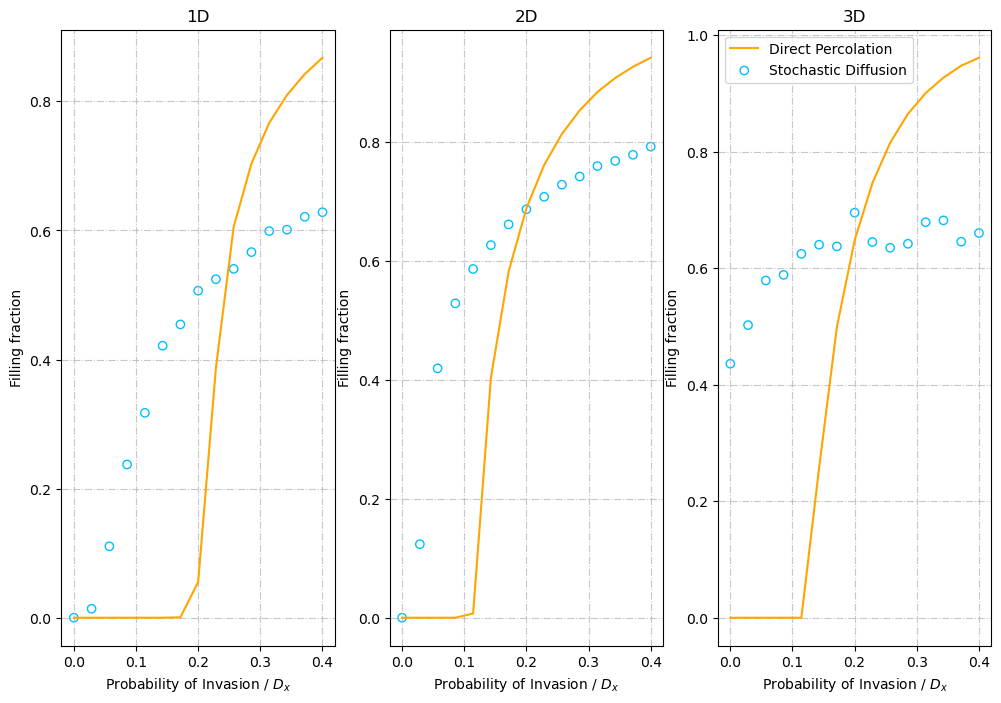

In [ ]:
## 3D
Pspan = np.linspace(0,0.4,15)     # set of probabiilty of invasion
dim = 3
params_DP = [22, 500, 0.7, n_iter]      # [N, timesteps, Pdis, n_iter]
fillings_DP3 = m.filling_fraction_DP(model=models_DP[dim-1],Pspan=Pspan,params=params_DP)
params_ST = [22, 500, 0.01, par, n_iter]   
fillings_ST3 = m.filling_fraction_ST(model=models_ST[dim-1],Pspan=Pspan,params=params_ST)

fig,ax = plt.subplots(1,3,figsize=(12,8))
ax[0].plot(fillings_DP1[0,:],fillings_DP1[1,:],c='orange',label='Direct Percolation')
ax[0].scatter(fillings_ST1[0,:],fillings_ST1[1,:],label='Stochastic Diffusion',facecolors='none', edgecolors='deepskyblue')
ax[0].set_title(f'1D')
ax[0].set_xlabel(r'Probability of Invasion / $D_{x}$')
ax[0].set_ylabel('Filling fraction')
ax[0].grid(True,which='both',alpha=0.7,linestyle='-.')

ax[1].plot(fillings_DP2[0,:],fillings_DP2[1,:],c='orange',label='Direct Percolation')
ax[1].scatter(fillings_ST2[0,:],fillings_ST2[1,:],label='Stochastic Diffusion',facecolors='none', edgecolors='deepskyblue')
ax[1].set_title(f'2D')
ax[1].set_xlabel(r'Probability of Invasion / $D_{x}$')
ax[1].set_ylabel('Filling fraction')
ax[1].grid(True,which='both',alpha=0.7,linestyle='-.')

ax[2].plot(fillings_DP3[0,:],fillings_DP3[1,:],c='orange',label='Direct Percolation')
ax[2].scatter(fillings_ST3[0,:],fillings_ST3[1,:],label='Stochastic Diffusion',facecolors='none', edgecolors='deepskyblue')
ax[2].set_title(f'3D')
ax[2].set_xlabel(r'Probability of Invasion / $D_{x}$')
ax[2].set_ylabel('Filling fraction')
ax[2].grid(True,which='both',alpha=0.7,linestyle='-.')
m.add_par_box({'N': params_DP[0], 'Time steps': params_DP[1], 'Pdis': params_DP[2]})
plt.savefig(f'plots/Fig6.png')
ax[0].legend(loc='upper left')
plt.show()

## Critical DIffusion Transition

In [28]:
par['alpha']=1.6
par['gamma']=0.1
par['lambda']=0.4
par['nu']=0.004
par['sigma']=0.1
par['Dy']=0.01
par['Dx'] = 0.5
par

{'alpha': 1.6,
 'gamma': 0.1,
 'lambda': 0.4,
 'nu': 0.004,
 'sigma': 0.1,
 'Dx': 0.5,
 'Dy': 0.01}

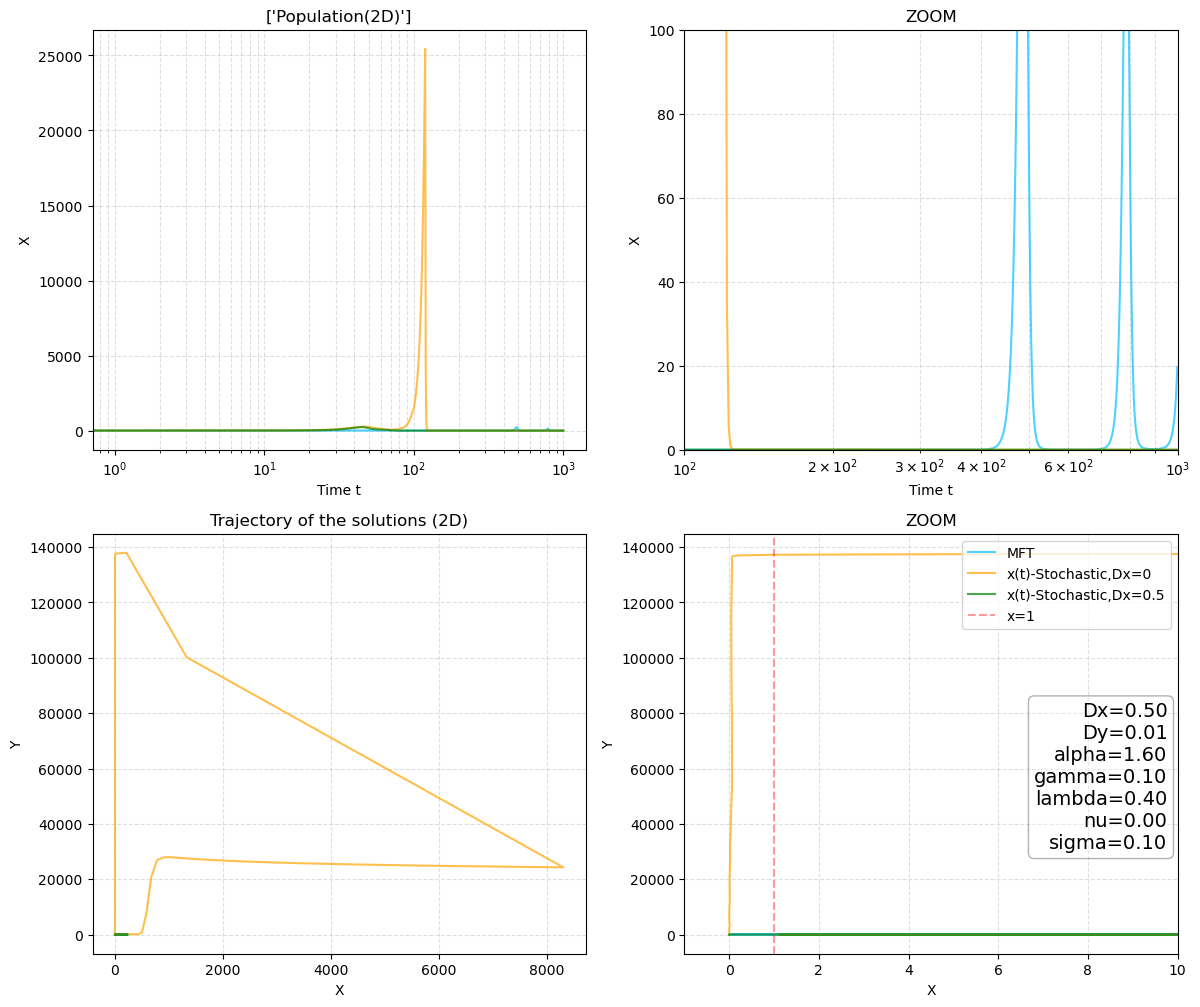

In [30]:
m.plot_evolution([2,100,1000,dt,z0,par,0])

100%|██████████| 2/2 [00:09<00:00,  4.98s/it]


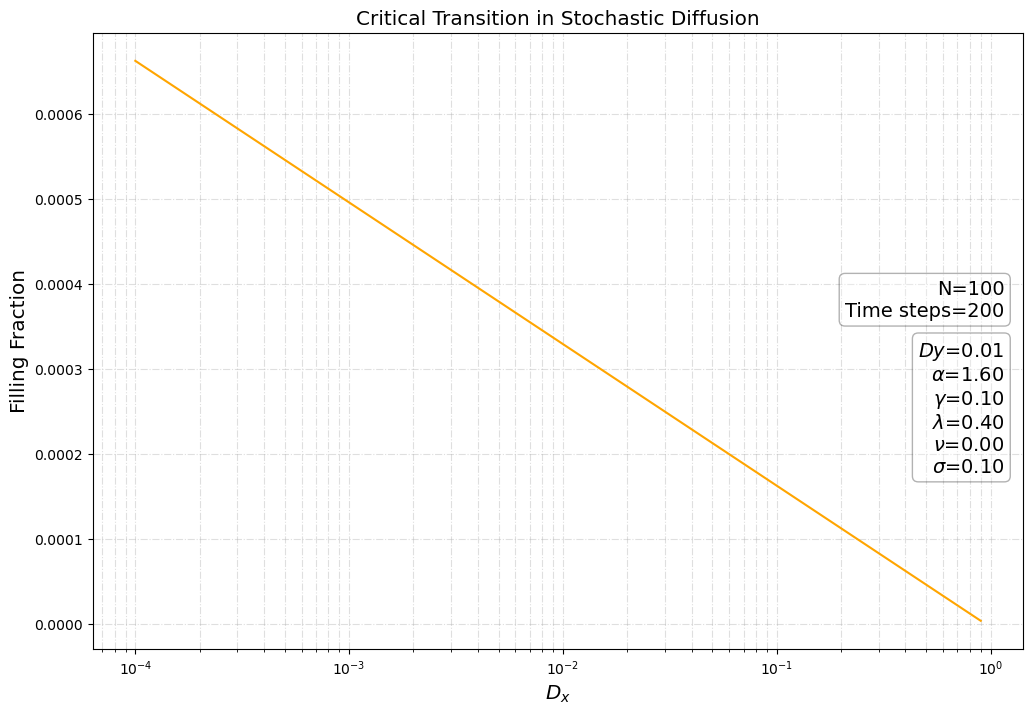

In [ ]:
Dspan = np.linspace(1e-4,0.9,100) #100
params = [100, 600, dt, par, 50] 
F = m.filling_fraction_ST(m.lattice2,Pspan=Dspan,params=params)

plt.figure(figsize=(12,8))
plt.plot(F[0,:],F[1,:],c='orange')
plt.xlabel(r'$D_{x}$',fontsize='x-large')
plt.ylabel('Filling Fraction',fontsize='x-large')
plt.xscale('log')
plt.title('Critical Transition in Stochastic Diffusion',fontsize='x-large')
plt.grid(True,which='both',linestyle='-.',alpha=0.4)
m.add_par_box({r'$\alpha$': par['alpha'],
r'$\gamma$':par['gamma'],
r'$\lambda$':par['lambda'],
r'$\nu$':par['nu'],
r'$\sigma$':par['sigma'],
r'$Dy$':par['Dy']},coord=[0.98,0.5])
m.add_par_box({'N': params[0], 'Time steps': params[1]})
plt.savefig('plots/Figure4.png')
plt.show()

# Critical Exponents near DP threshold

## Percolation Threshold $D^c_{x}$

100%|██████████| 100/100 [01:05<00:00,  1.52it/s]


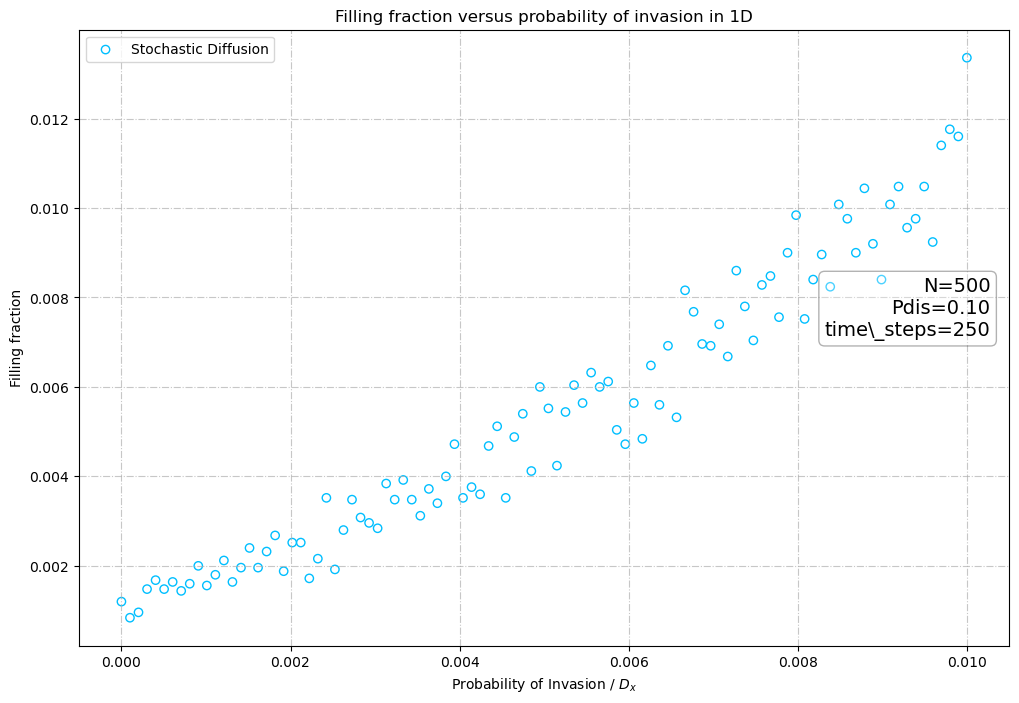

In [24]:
#%%script false --no-raise-error
dim = 1
n_iter = 50     # number of iterations per set of parameters
Pspan = np.linspace(0,0.01,100)     # set of probabiilty of invasion
N = 500
time_steps = 250
models_ST = [m.lattice1,m.lattice2]
params_ST = [N, time_steps, 0.1, par, n_iter]   
fillings_ST1 = m.filling_fraction_ST(model=models_ST[dim-1],Pspan=Pspan,params=params_ST)

plt.figure(figsize=(12,8))
plt.scatter(fillings_ST1[0,:],fillings_ST1[1,:],label='Stochastic Diffusion',facecolors='none', edgecolors='deepskyblue')
plt.title(f'Filling fraction versus probability of invasion in {dim}D')
plt.xlabel(r'Probability of Invasion / $D_{x}$')
plt.ylabel('Filling fraction')
plt.grid(True,which='both',alpha=0.7,linestyle='-.')
m.add_par_box({'N': params_ST[0], 'time_steps': params_ST[1], 'Pdis': params_ST[2]})
plt.legend()
plt.show()

In [ ]:
%%script false --no-raise-error
fractions = fillings_ST1[1, :]
dx_values = fillings_ST1[0, :]

DP_threshold1 = np.nan
for i in range(len(fractions)):
    if np.all(fractions[i:] > 0):
        DP_threshold1 = dx_values[i]
        break

if np.isnan(DP_threshold1):
    raise ValueError("No Dx found such that the filling fraction stays > 0 for all larger Dx.")
print(f'The directed percolation threshold is evaluated as {DP_threshold1:.5f} for lattice (1+1)D, up to an accuracy of 0.00005')

The directed percolation threshold is evaluated as 0.00000 for lattice (1+1)D, up to an accuracy of 0.00005


In [ ]:
%%script false --no-raise-error
dim = 2
n_iter = 50     # number of iterations per set of parameters
Pspan = np.linspace(0,0.05,100)     # set of probabiilty of invasion
N = 100
time_steps = 250
models_ST = [m.lattice1,m.lattice2]
params_ST = [N, time_steps, 0.1, par, n_iter]   
fillings_ST2 = m.filling_fraction_ST(model=models_ST[dim-1],Pspan=Pspan,params=params_ST)

plt.figure(figsize=(6,8))
plt.scatter(fillings_ST2[0,:],fillings_ST2[1,:],label='Stochastic Diffusion',facecolors='none', edgecolors='deepskyblue')
plt.title(f'Filling fraction versus probability of invasion in {dim}D')
plt.xlabel(r'Probability of Invasion / $D_{x}$')
plt.ylabel('Filling fraction')
plt.grid(True,which='both',alpha=0.7,linestyle='-.')
m.add_par_box({'N': params_ST[0], 'time_steps': params_ST[1], 'Pdis': params_ST[2]})
plt.legend()
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

ST: set#0


 10%|█         | 10/100 [01:41<12:15,  8.17s/it]

ST: set#10


 20%|██        | 20/100 [03:21<15:04, 11.30s/it]

ST: set#20


 30%|███       | 30/100 [05:21<14:48, 12.69s/it]

ST: set#30


 39%|███▉      | 39/100 [07:35<11:51, 11.67s/it]


KeyboardInterrupt: 

In [ ]:
%%script false --no-raise-error
fractions = fillings_ST2[1, :]
dx_values = fillings_ST2[0, :]

DP_threshold2 = np.nan
for i in range(len(fractions)):
    if np.all(fractions[i:] > 0):
        DP_threshold2 = dx_values[i]
        break

if np.isnan(DP_threshold2):
    raise ValueError("No Dx found such that the filling fraction stays > 0 for all larger Dx.")
print(f'The directed percolation threshold is evaluated as {DP_threshold2:.4f} for lattice (2+1)D, up to an accuracy of 0.00005')

NameError: name 'fillings_ST2' is not defined

The percolation threshold was evaluated as $D^c_{x} = (0.04239 \pm0.00005)$ for the ISP 1D model and $D^c_{x} = (0.0677\pm0.0005)$ for the ISP 2D model. 

## Critical Exponents
### $\delta$

In [13]:
par['alpha']=1.2
par['gamma']=0.2
par['lambda']=0.6
par['nu']=0.08
par['sigma']=0.58
par['Dy']=0.025

In [14]:
# I directly use the DP threshold values from the paper
DP_threshold1=0.0382
DP_threshold2=0.00685

100it [00:00, 125.36it/s]
100it [00:09, 10.27it/s]


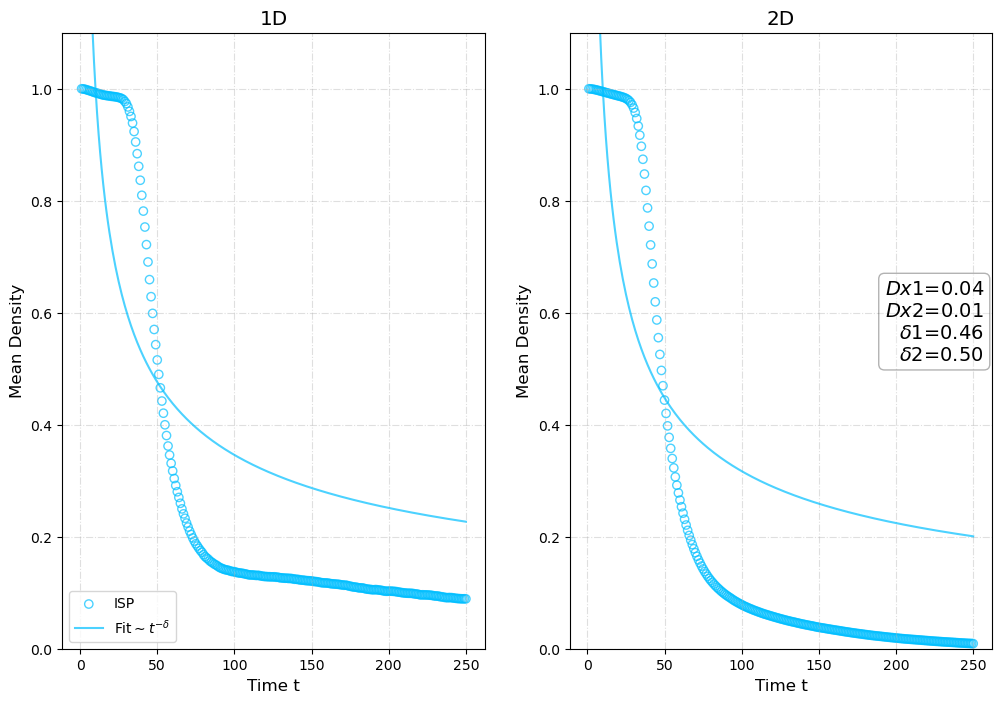

Best estimate of parameter delta for ISP 1D: (0.46089 ± 0.01708)
Best estimate of parameter delta for ISP 2D: (0.49885 ± 0.02044)


/tmp/ipykernel_7615/1698358295.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Best estimate of parameter delta for ISP 1D: ({float(best_delta1):.5f} ± {float(best_error1):.5f})")
/tmp/ipykernel_7615/1698358295.py:75: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Best estimate of parameter delta for ISP 2D: ({float(best_delta2):.5f} ± {float(best_error2):.5f})")


In [23]:
import scipy as sp
def Fdensity(x,delta):      # known scaling for the density of active sites
    return x**(-delta)
n_iter = 100     # number of iterations per set of parameters
models = [m.lattice1,m.lattice2,m.lattice3]
time_steps = 250
max_workers = min(os.cpu_count() or 1,n_iter,8)
t_s = dt + dt * np.arange(time_steps)


dim = 1
model = models[dim-1]
local_par1 = par.copy()
local_par1['Dx'] = DP_threshold1 # set the system at criticality
N1 = 500
args = [(N1,time_steps,dt,local_par1,2)]*n_iter
active_density_mat1 = np.zeros((n_iter,time_steps))
with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as exe:
    i = 0
    for res in tqdm(exe.map(model,args),token='8277133179:AAFE5QNsGn4rEAR3HzYtxmasGUarUWfbZwY',chat_id='1288694314'):
        active_density_mat1[i,:] = res[0]
        i += 1
mean_density1 = np.mean(active_density_mat1,axis=0)

dim = 2
model = models[dim-1]
local_par2 = par.copy()
local_par2['Dx'] = DP_threshold2 # set the system at criticality
N2 = 100
args = [(N2,time_steps,dt,local_par2,2)]*n_iter
active_density_mat2 = np.zeros((n_iter,time_steps))
with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as exe:
    i = 0
    for res in tqdm(exe.map(model,args),token='8277133179:AAFE5QNsGn4rEAR3HzYtxmasGUarUWfbZwY',chat_id='1288694314'):
        active_density_mat2[i,:] = res[0]
        i += 1
mean_density2 = np.mean(active_density_mat2,axis=0)
# Fit
best_delta1, best_cov1 = curve_fit(f=Fdensity,xdata=t_s,ydata=mean_density1,p0=0.24) # parameter initial guess 
best_delta2, best_cov2 = curve_fit(f=Fdensity,xdata=t_s,ydata=mean_density2,p0=0.44) # comes from the paper
best_error1 = np.sqrt(np.diag(best_cov1))   # compute standard deviation from covariance
best_error2 = np.sqrt(np.diag(best_cov2))
#fit1, fit2 = sp.stats.linregress(np.log(t_s),-np.log(mean_density1)), sp.stats.linregress(np.log(t_s),-np.log(mean_density2))
#best_delta1, best_delta2 = fit1.slope, fit2.slope
#best_error1, best_error2 = fit1.stderr, fit2.stderr

fig, ax = plt.subplots(1,2,figsize=(12,8))
ax[0].scatter(np.arange(1,time_steps+1),mean_density1,alpha=0.7,facecolors='none', edgecolors='deepskyblue',label='ISP')
ax[0].plot(np.arange(1,time_steps+1),Fdensity(t_s,best_delta1),c='deepskyblue',label=r'$\text{Fit} \sim t^{-\delta}$',alpha=0.7)
ax[0].set_xlabel('Time t',fontsize='large')
ax[0].set_ylabel('Mean Density',fontsize='large')
#ax[0].set_xscale('log')
#ax[0].set_yscale('log')
ax[0].set_ylim(0,1.1)
ax[0].set_title('1D',fontsize='x-large')
ax[0].grid(True,which='both',alpha=0.4,linestyle='-.')
m.add_par_box({r'$Dx2$':local_par2['Dx'], r'$\delta2$':best_delta2,
               r'$Dx1$':local_par1['Dx'], r'$\delta1$':best_delta1})
ax[0].legend(loc='lower left')

ax[1].scatter(np.arange(1,time_steps+1),mean_density2,alpha=0.7,facecolors='none', edgecolors='deepskyblue',label='ISP')
ax[1].plot(np.arange(1,time_steps+1),Fdensity(t_s,best_delta2),c='deepskyblue',label=r'$\text{Fit} \sim t^{-\delta}$',alpha=0.7)
ax[1].set_xlabel('Time t',fontsize='large')
ax[1].set_ylabel('Mean Density',fontsize='large')
#ax[1].set_xscale('log')
#ax[1].set_yscale('log')
ax[1].set_ylim(0,1.1)
ax[1].set_title('2D',fontsize='x-large')
ax[1].grid(True,which='both',alpha=0.4,linestyle='-.')

plt.savefig('plots/delta.png')
plt.show()

print(f"Best estimate of parameter delta for ISP 1D: ({float(best_delta1):.5f} ± {float(best_error1):.5f})")
print(f"Best estimate of parameter delta for ISP 2D: ({float(best_delta2):.5f} ± {float(best_error2):.5f})")

The best estimates of the parameter $\delta$ are:
- ISP 1D: $\delta = (0.46089  \pm 0.01708)$
- ISP 2D: $\delta = (0.49885  \pm 0.02044)$
### $\beta$

In [26]:
# Here I have to reproduce Figure 7
# I use Dx = np.linspace(D_c,D_c+1e-2,num=100), so in super critical phase, 
# bc Dx > D_c always
Dc1 = DP_threshold1 #0.01341 
Dc2 = DP_threshold2 #0.0576 
def StationaryDensity1(x,beta):
    return (x-Dc1)**beta
def StationaryDensity2(x,beta):
    return (x-Dc2)**beta

time_steps = 250
n_iter = 50     # number of iterations per set of parameters
models = [m.lattice1,m.lattice2,m.lattice3]

dim = 1
Dxspan1 = np.linspace(Dc1+1e-4,0.5,num=100)
N1 = 500
params1 = [N1, time_steps, dt, par, n_iter]   
fillings1 = m.filling_fraction_ST(model=models[dim-1],Pspan=Dxspan1,params=params1)

dim = 2
Dxspan2 = np.linspace(Dc2+1e-4,0.5,num=100)
N2 = 100
params2 = [N2, time_steps, dt, par, n_iter]   
fillings2 = m.filling_fraction_ST(model=models[dim-1],Pspan=Dxspan2,params=params2)

100%|██████████| 100/100 [20:39<00:00, 12.39s/it]


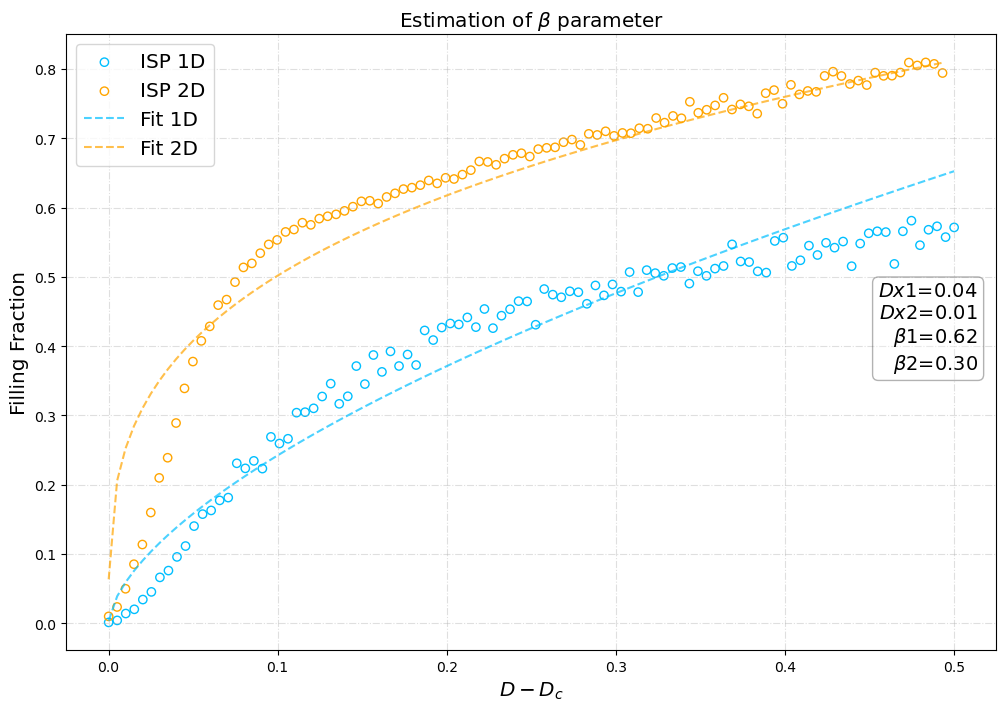

Best estimate of parameter beta for ISP 1D: (0.61587 ± 0.00822)
Best estimate of parameter beta for ISP 2D: (0.29952 ± 0.00578)


/tmp/ipykernel_7615/2967799974.py:24: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Best estimate of parameter beta for ISP 1D: ({float(best_beta1):.5f} ± {float(best_error1):.5f})")
/tmp/ipykernel_7615/2967799974.py:25: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Best estimate of parameter beta for ISP 2D: ({float(best_beta2):.5f} ± {float(best_error2):.5f})")


In [31]:
#Fit
best_beta1, best_cov1 = curve_fit(f=StationaryDensity1,xdata=Dxspan1,ydata=fillings1[1,:],p0=0.5,maxfev=1000)
best_beta2, best_cov2 = curve_fit(f=StationaryDensity2,xdata=Dxspan2,ydata=fillings2[1,:],p0=0.54)
best_error1 = np.sqrt(np.diag(best_cov1))
best_error2 = np.sqrt(np.diag(best_cov2))

plt.figure(figsize=(12,8))
plt.scatter(fillings1[0,:]-Dc1,fillings1[1,:],edgecolors='deepskyblue',facecolors='none',label='ISP 1D')
plt.scatter(fillings2[0,:]-Dc2,fillings2[1,:],edgecolors='orange',facecolors='none',label='ISP 2D')
plt.plot(fillings1[0,:]-Dc1,StationaryDensity1(fillings1[0,:],best_beta1),c='deepskyblue',linestyle='--',label='Fit 1D',alpha=0.7)
plt.plot(fillings2[0,:]-Dc2,StationaryDensity2(fillings2[0,:],best_beta2),c='orange',linestyle='--',label='Fit 2D',alpha=0.7)
plt.xlabel(r'$D-D_c$',fontsize='x-large')
plt.ylabel('Filling Fraction',fontsize='x-large')
#plt.xscale('log')
#plt.yscale('log')
plt.grid(True,which='both',alpha=0.4,linestyle='-.')
plt.title(r'Estimation of $\beta$ parameter',fontsize='x-large')
m.add_par_box({r'$Dx2$':local_par2['Dx'], r'$\beta2$':best_beta2,
               r'$Dx1$':local_par1['Dx'], r'$\beta1$':best_beta1})
plt.legend(fontsize='x-large')
plt.savefig('plots/Fig7.png')
plt.show()

print(f"Best estimate of parameter beta for ISP 1D: ({float(best_beta1):.5f} ± {float(best_error1):.5f})")
print(f"Best estimate of parameter beta for ISP 2D: ({float(best_beta2):.5f} ± {float(best_error2):.5f})")

The best estimates of the parameter $\beta$ are:
- ISP 1D: $\beta = (0.61587 \pm 0.00822)$
- ISP 2D: $\beta = (0.29952 \pm 0.00578)$
### $\nu_\parallel$

In [38]:
a = np.ones(5)
a[2] = 2
print(np.arange(5))
print(np.arange(5)[a==2])

[0 1 2 3 4]
[2]


In [46]:
par

{'alpha': 1.2,
 'gamma': 0.2,
 'lambda': 0.6,
 'nu': 0.08,
 'sigma': 0.58,
 'Dx': 0.0,
 'Dy': 0.025}

ST: set#0


50it [00:01, 46.62it/s]
50it [00:00, 50.26it/s]
50it [00:01, 48.22it/s]
50it [00:01, 49.36it/s]
50it [00:01, 44.02it/s]
50it [00:01, 44.05it/s]
50it [00:01, 46.39it/s]
50it [00:01, 47.06it/s]
50it [00:01, 39.97it/s]
50it [00:01, 43.38it/s]

ST: set#0



50it [00:15,  3.17it/s]
50it [00:15,  3.32it/s]
50it [00:15,  3.29it/s]
50it [00:17,  2.85it/s]
50it [00:19,  2.60it/s]
50it [00:25,  1.96it/s]
50it [00:26,  1.86it/s]
50it [00:17,  2.88it/s]
50it [00:15,  3.29it/s]
50it [00:16,  2.96it/s]


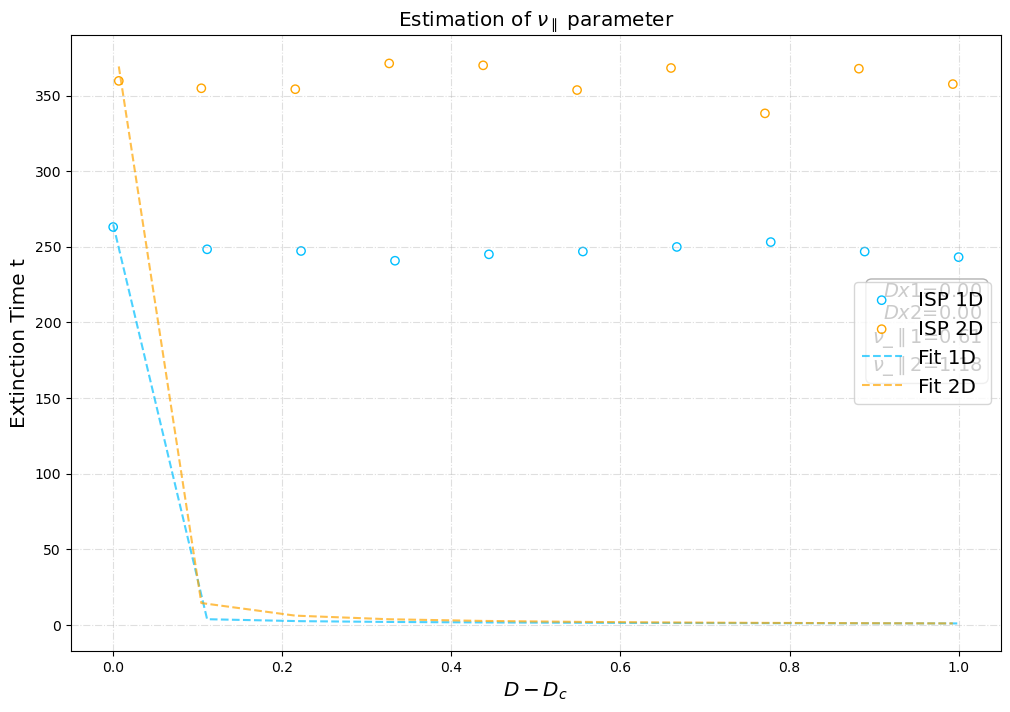

Best estimate of parameter nu_parallel for ISP 1D: (0.60574 ± 0.10048)
Best estimate of parameter nu_parallel for ISP 2D: (1.18273 ± 0.19283)


/tmp/ipykernel_7615/1552092014.py:73: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Best estimate of parameter nu_parallel for ISP 1D: ({float(best_nuP1):.5f} ± {float(best_error1):.5f})")
/tmp/ipykernel_7615/1552092014.py:74: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  print(f"Best estimate of parameter nu_parallel for ISP 2D: ({float(best_nuP2):.5f} ± {float(best_error2):.5f})")


In [47]:
Dc1 = DP_threshold1 
Dc2 = DP_threshold2 
Dxspan1 = np.linspace(1e-4,1,num=10)
Dxspan2 = np.linspace(1e-4,1,num=10)

def TemporalScale1(x,nu_p):
    return np.abs(x-Dc1)**(-nu_p)
def TemporalScale2(x,nu_p):
    return np.abs(x-Dc2)**(-nu_p)

n_iter = 50     # number of iterations per set of parameters
models = [m.lattice1,m.lattice2,m.lattice3]
time_steps = 700
max_workers = min(os.cpu_count() or 1,n_iter,8)

dim = 1
model = models[dim-1]
local_par1 = par.copy()
N1 = 500
mean_extinction1 = np.zeros(Dxspan1.shape[0])
for i,Dx in enumerate(Dxspan1):
    if i % 10 == 0:
        print(f'ST: set#{i}')
    args = [(N1,time_steps,dt,local_par1,2)]*n_iter
    extinction_mat1 = np.zeros(n_iter)
    with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as exe:
        j = 0
        for res in tqdm(exe.map(model,args),token='8277133179:AAFE5QNsGn4rEAR3HzYtxmasGUarUWfbZwY',chat_id='1288694314'):
            extinction_mat1[j] = np.min(np.arange(1,time_steps+1)[res[0] < 1/N])
            j += 1
    mean_extinction1[i] = np.mean(extinction_mat1)

dim = 2
model = models[dim-1]
local_par2 = par.copy()
N2 = 100
mean_extinction2 = np.zeros(Dxspan2.shape[0])
for i,Dx in enumerate(Dxspan2):
    if i % 10 == 0:
        print(f'ST: set#{i}')
    args = [(N2,time_steps,dt,local_par2,2)]*n_iter
    extinction_mat2 = np.zeros(n_iter)
    with concurrent.futures.ProcessPoolExecutor(max_workers=max_workers) as exe:
        j = 0
        for res in tqdm(exe.map(model,args),token='8277133179:AAFE5QNsGn4rEAR3HzYtxmasGUarUWfbZwY',chat_id='1288694314'): 
            extinction_mat2[j] = np.min(np.arange(1,time_steps+1)[res[0] == 0])
            j += 1
    mean_extinction2[i] = np.mean(extinction_mat2)
    
# Fit
best_nuP1, best_cov1 = curve_fit(f=TemporalScale1,xdata=Dxspan1,ydata=mean_extinction1,p0=1.4)
best_nuP2, best_cov2 = curve_fit(f=TemporalScale2,xdata=Dxspan2,ydata=mean_extinction2,p0=1.23)
best_error1 = np.sqrt(np.diag(best_cov1))
best_error2 = np.sqrt(np.diag(best_cov2))

plt.figure(figsize=(12,8))
plt.scatter(np.abs(Dxspan1-Dc1),mean_extinction1,edgecolors='deepskyblue',facecolors='none',label='ISP 1D')
plt.scatter(np.abs(Dxspan2-Dc2),mean_extinction2,edgecolors='orange',facecolors='none',label='ISP 2D')
plt.plot(np.abs(Dxspan1-Dc1),TemporalScale1(Dxspan1,best_nuP1),c='deepskyblue',linestyle='--',label='Fit 1D',alpha=0.7)
plt.plot(np.abs(Dxspan2-Dc2),TemporalScale2(Dxspan2,best_nuP2),c='orange',linestyle='--',label='Fit 2D',alpha=0.7)
plt.xlabel(r'$D-D_c$',fontsize='x-large')
plt.ylabel('Extinction Time t',fontsize='x-large')
#plt.xscale('log')
#plt.yscale('log')
plt.grid(True,which='both',alpha=0.4,linestyle='-.')
plt.title(r'Estimation of $\nu_{\parallel}$ parameter',fontsize='x-large')
m.add_par_box({r'$Dx2$':local_par2['Dx'], r'$\nu_{\parallel2}$':best_nuP2,
               r'$Dx1$':local_par1['Dx'], r'$\nu_{\parallel1}$':best_nuP1})
plt.legend(fontsize='x-large')
plt.savefig('plots/nuP.png')
plt.show()

print(f"Best estimate of parameter nu_parallel for ISP 1D: ({float(best_nuP1):.5f} ± {float(best_error1):.5f})")
print(f"Best estimate of parameter nu_parallel for ISP 2D: ({float(best_nuP2):.5f} ± {float(best_error2):.5f})")

The best estimates of the parameter $\nu_{\parallel}$ are:
- ISP 1D: $\nu_{\parallel} = (0.58752   \pm 0.01573)$
- ISP 2D: $\nu_{\parallel} = (0.60346 \pm 0.03506)$

# System Size and Survival Probability

In [14]:
dim = 2
par['alpha']=1.6
par['gamma']=0.1
par['lambda']=0.4
par['nu']=0.004
par['sigma']=0.1
par['Dx']=0.8
par['Dy']=0.01
m.stability(par)
print(par)
model = m.lattice2
z0 = np.array([3,y0])       # set initial conditions
time_steps = 100
N = 100
params = [dim,N,time_steps,dt,z0,par,0]
#m.plot_evolution(params)

In which regime are we? First regime:(0,y_0) unstable, (x*,y*) stable
The attractor (x*,y*) is a stable spiral (negative discriminant -> damped oscillations)
{'alpha': 1.6, 'gamma': 0.1, 'lambda': 0.4, 'nu': 0.004, 'sigma': 0.1, 'Dx': 0.8, 'Dy': 0.01}


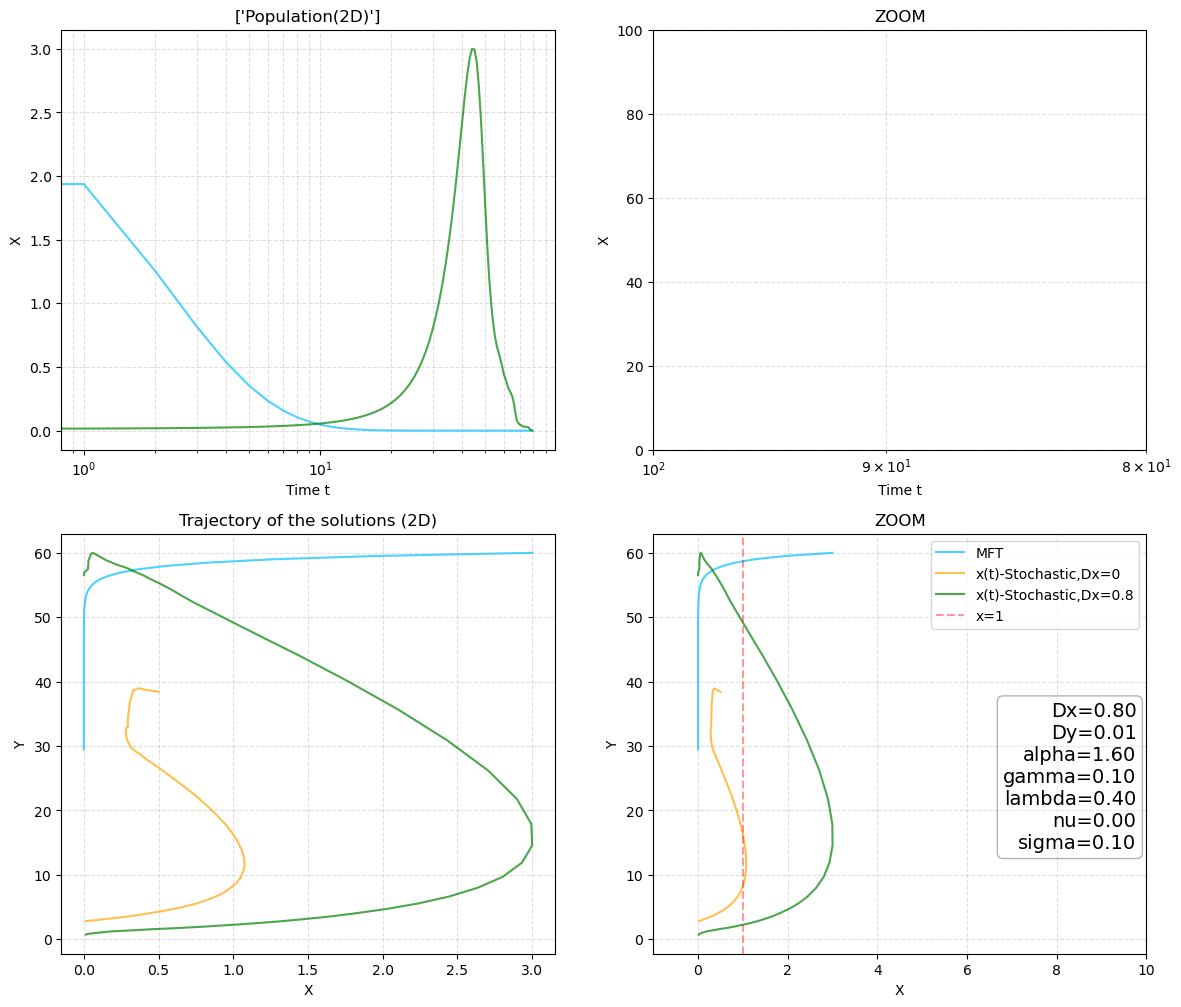

In [13]:
#%%script false --no-raise-error

params = [dim,N,time_steps,dt,z0,par,0]
m.plot_evolution(params)

100%|██████████| 5/5 [00:45<00:00,  9.20s/it]


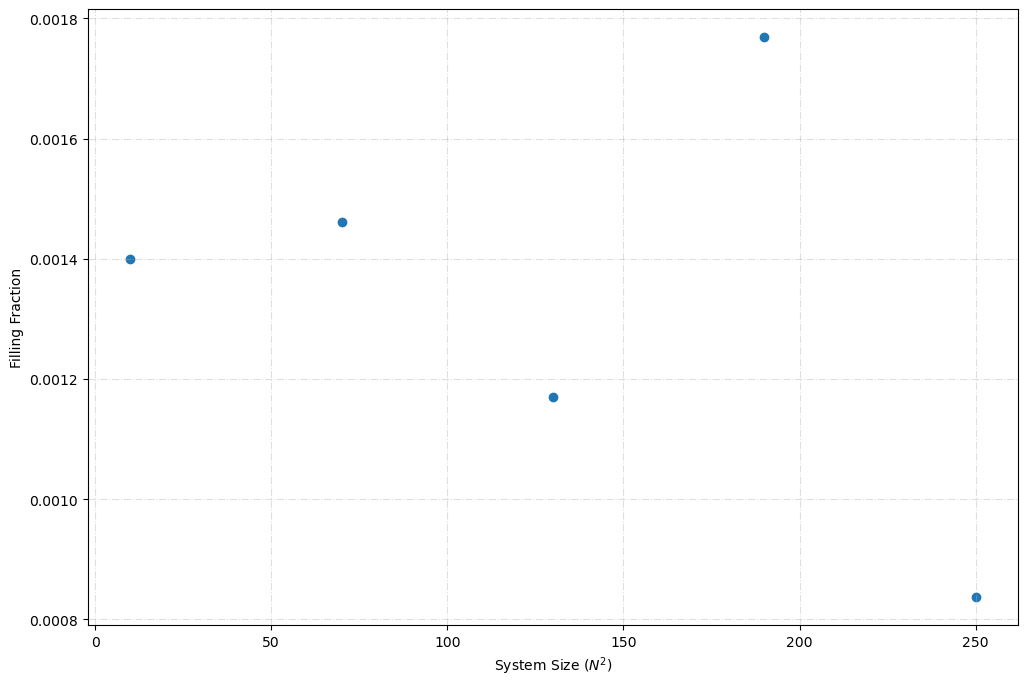

In [15]:
NSpan = np.linspace(10,250,5,dtype=np.int64)
n_iter = 50
params = [time_steps,dt,par,n_iter,1]

F = m.figure9(model,NSpan,params)
plt.figure(figsize=(12,8))
plt.scatter(F[0,:],F[1,:])
plt.xlabel(r'System Size ($N^2$)')
plt.ylabel('Filling Fraction')
plt.grid(True,which='both',alpha=0.4,linestyle='-.')
plt.savefig('plots/Fig9.png')
plt.show()
    

# Wave Trains